In [1]:
import itertools
import numpy as np
from nltk.corpus import stopwords
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import networkx as nx
from ast import literal_eval
from statistics import median
from sklearn.cluster import KMeans
from networkx.algorithms.community import kernighan_lin_bisection
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms import community
from nltk.tokenize import MWETokenizer
import time
import community as community_louvain
import matplotlib.cm as cm

In [2]:
url = 'data/'
url_image='image_data/'

### Import nodes, edges dataframes

In [3]:
# Reading a csv file that contains nodes of the graph
df_node = pd.read_csv(url+'df_nodes_algorithms.csv', converters={'tf-idf': eval, 'tf-idf_after_norm':eval,'wordvec':eval})
print('number of nodes:',df_node.shape[0])

number of nodes: 514


In [4]:
df_node.head()

,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587


In [5]:
# Reading a csv file that contains edges of the graph
edges_df = pd.read_csv(url+'df_edges_algorithms.csv')
print('number of edges:',edges_df.shape)

number of edges: (105111, 4)


In [6]:
edges_df.head()

,node1,node2,cosine_similarity,distance
0,0,1,0.238468,0.737669
1,0,2,0.146363,0.614132
2,0,3,0.193370,0.555648
3,0,4,0.123058,0.750495
4,0,5,0.151529,0.633940


# Algorithms

***Filtered words with values ​​below the median***

In [7]:
print('Median value:',median(edges_df['distance']))

Median value: 0.5950751179770357


In [8]:
# Filtered words with values ABOVE the median(keep edges this small distance)
edges_df_median =edges_df[edges_df['distance'] < median(edges_df['distance'])]
print('Number of edges after Median:',edges_df_median.shape[0])

Number of edges after Median: 52555


In [9]:
# Save nodes data after removing nodes that are below the median value
edges_df_median.to_csv(url+'df_median_edges.csv', index=False,header=True)

In [10]:
# Import node data from a file
edges_df_median = pd.read_csv(url+'df_median_edges.csv')
edges_df_median.head()

,node1,node2,cosine_similarity,distance
0,0,3,0.193370,0.555648
1,0,6,0.324075,0.520101
2,0,8,0.183857,0.582612
3,0,9,0.229114,0.573253
4,0,12,0.234580,0.579093


# ***Communities algorithms***

In [11]:
%%time
# Create a new graph after filtering words by median
H = nx.Graph()
H.add_nodes_from(range(df_node.shape[0]))
H.add_edges_from(zip(edges_df_median['node1'], edges_df_median['node2']))


Wall time: 78.8 ms


In [12]:
def communities_paint(G,communities,labels,title):
    """
    Paint communities function
    Function that accepts as arguments: graph, list of communities, labels and name of the algorithm.
    And returns a graph of communities according to the type of algorithm.
    """
    pos=nx.spring_layout(G, iterations=1)
    
    colors = ['b','g','r','c','m','y','k','w','#eeefff','#00FFFF','#6495ED', '#A7C7E7', '#9FE2BF', '#CD7F32', '#E97451', '#F0E68C', '#CC7722','#FF00FF','#C0C0C0','#800080','#008080','ivory','gold','olive','khaki']
    color_num =0
    for nodelist in communities:
        nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_color=colors[color_num],
                       node_size=100,
                   alpha=0.8)
        color_num +=1
        
    nx.draw_networkx_edges(G,pos,width=0.8,alpha=0.5)     
    
    nx.draw_networkx_labels(G, pos, labels,font_size=10)
    plt.gcf().set_size_inches(8,8)  
    plt.axis('off')
    plt.savefig(url_image+title+'.png')  
    plt.show() 
    plt.close()

In [13]:
# Create a dictionary where the key is the vertex value and the value is the vertex name for networkx algorithms
labels = dict((key, list(df_node.word[df_node.index ==key].values)[0]) for key in list(H.nodes()))

***Girvan_newman algorithm***

In [14]:
print("Number of levels in the girvan_newman algorithm: ",len(list(girvan_newman(H))))
print(list(girvan_newman(H)))

Number of levels in the girvan_newman algorithm:  90
[({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99}, {17}, {25}, {32}, {38}, {43}, {65}, {72}, {80}, {85}, {91}), ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99}, {17}, {25}, {32}, {38}, {43}, {49}, {65}, {72}, {80}, {85}, {91}), ({0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34,

In [15]:
def communities_lenght_girvan_newman(G,max_communities_number):
    """
    Show split to communities per level
    """
    from networkx.algorithms import community
    level_number = 0
    for level in list(community.girvan_newman(G)):
        number_of_communities = len(tuple(sorted(c) for c in level))
        if number_of_communities <= max_communities_number:
            print('level number :',level_number,'number of communities: ', number_of_communities)
            level_number +=1
            communities_len = []
            for community in level:
                communities_len.append(len(community))
            print(communities_len)          
        else:
            break

In [16]:
communities_lenght_girvan_newman(H,5)

In [17]:
def split_girvan_newman(G,communities_number):
    """
    Girvan_newman algorithm
    """
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)
    if communities_number > 0:
        for i in range(communities_number):
            next_level_communities = next(communities_generator)
        return sorted(map(sorted, next_level_communities))
    else:
        return sorted(map(sorted, top_level_communities))


In [18]:
def communities_words_list(community_list,df_node):
    """
    A function that receives a list of node numbers, converts a node number to its word value.
    The function returns a list of the word value.
    """
    communities_words = []
    for click in range(len(community_list)):
        word_click = []
        for i in community_list[click]:
            word_click.append(list(df_node.word[df_node.index ==i].values)[0])
        communities_words.append(word_click) 
    return   communities_words

In [19]:
communities = split_girvan_newman(H,2)
print("The number of communities divided by the girvan_newman algorithm: ",len(communities))
# Displays multiple nodes that appear in each community
print(communities)

The number of communities divided by the girvan_newman algorithm:  13
[[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99], [1], [17], [25], [32], [38], [43], [49], [65], [72], [80], [85], [91]]


In [20]:
# Display the words that appear in each community
communities_words=communities_words_list(communities,df_node)
print(communities_words)

[['modern', 'used', 'among', 'enabling', 'secure', 'degree', 'ideas', 'collaboration', 'member', 'drive', 'verbal', 'support', 'life', 'state', 'medical', 'scale', 'azure', 'insightful', 'pipeline', 'scalable', 'qa', 'great', 'tool', 'fields', 'leadership', 'content', 'programming', 'technique', 'app', 'computer', 'take', 'current', 'html', 'independent', 'around', 'leader', 'cross', 'execution', 'areas', 'future', 'monitoring', 'market', 'planning', 'professionals', 'key', 'focus', 'learn', 'time', 'build', 'ways', 'management', 'analytical', 'helps', 'javascript', 'major', 'today', 'contribution', 'cyber', 'group', 'set', 'talent', 'various', 'code', 'interpersonal', 'client', 'innovation', 'jerusalem', 'methods', 'include', 'like', 'provides', 'operation', 'job', 'entire', 'algorithms', 'talents', 'response', 'protocols', 'make', 'professional', 'office', 'comes', 'expert', 'hundreds', 'smart', 'practice', 'complex', 'preferred'], ['saas'], ['team_members'], ['jenkins'], ['informati

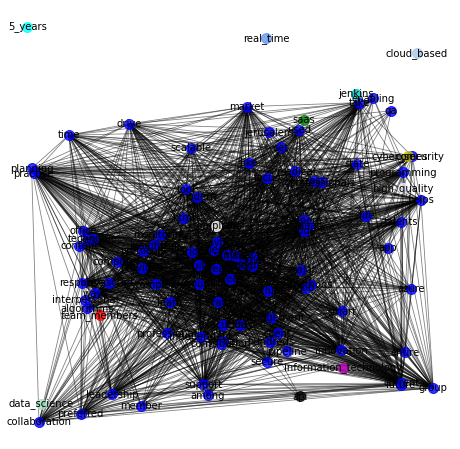

In [21]:
# Graph of girvan_newman
communities_paint(H,communities,labels,'girvan_newman_graph')

In [22]:
def add_number_cluster(df_node,communities_words,name_communities): 
    '''
    A function that receives a data frame of the graph vertices, 
    a list of lists that describes the clusters and the name of the algorithm.
    The function adds a column to a data frame with cluster values.
    '''
    dict_temp={}
    for i in range(len(communities_words)):
        dict_temp.update(dict.fromkeys(communities_words[i], i))
    df_cluster=pd.DataFrame(list(dict_temp.items()),columns = ['word',name_communities])
    return pd.merge(df_node, df_cluster, on=("word"))

In [23]:
df_girvan_newman=add_number_cluster(df_node,communities_words,'girvan_newman')

In [24]:
df_girvan_newman.head()

,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity,girvan_newman
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459,0
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757,1
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574,0
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322,0
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587,0


In [25]:
# Save in the file all the data for the clusters
df_girvan_newman.to_csv(url+'girvan_newman.csv',index=False)

***Kernighan–Lin bipartition algorithm***

In [26]:
kernighan = kernighan_lin_bisection(H, seed=1)
print("The number of communities divided by the Kernighan–Lin bipartition algorithm: ",len(kernighan))
# Displays multiple nodes that appear in each community
print(list(kernighan)) 

The number of communities divided by the Kernighan–Lin bipartition algorithm:  2
[{4, 5, 6, 7, 9, 11, 15, 18, 19, 20, 21, 24, 25, 27, 28, 29, 30, 31, 33, 36, 37, 38, 42, 44, 46, 47, 49, 50, 51, 52, 53, 58, 60, 63, 64, 65, 66, 73, 74, 76, 79, 80, 82, 84, 87, 88, 90, 91, 94, 99}, {0, 1, 2, 3, 8, 10, 12, 13, 14, 16, 17, 22, 23, 26, 32, 34, 35, 39, 40, 41, 43, 45, 48, 54, 55, 56, 57, 59, 61, 62, 67, 68, 69, 70, 71, 72, 75, 77, 78, 81, 83, 85, 86, 89, 92, 93, 95, 96, 97, 98}]


In [27]:
# Display the words that appear in each community
kernighan = kernighan_lin_bisection(H)
communities_words=communities_words_list(kernighan,df_node)
print(communities_words)

[['modern', 'saas', 'enabling', 'state', 'medical', 'team_members', 'azure', 'pipeline', 'scalable', 'qa', 'jenkins', 'fields', 'leadership', 'programming', 'app', 'information_technology', 'computer', 'current', 'html', 'independent', 'api', 'areas', 'monitoring', 'market', 'compliant', 'professionals', 'learn', 'build', 'management', 'analytical', 'javascript', 'cyber', 'high_quality', 'various', '5_years', 'client', 'innovation', 'jerusalem', 'methods', 'provides', 'real_time', 'operation', 'job', 'algorithms', 'cloud_based', 'protocols', 'professional', 'data_science', 'office', 'preferred'], ['used', 'among', 'secure', 'degree', 'ideas', 'collaboration', 'member', 'drive', 'verbal', 'support', 'life', 'scale', 'insightful', 'great', 'tool', 'content', 'technique', 'take', 'cyber_security', 'around', 'leader', 'cross', 'execution', 'future', 'planning', 'key', 'focus', 'time', 'ways', 'helps', 'major', 'today', 'contribution', 'group', 'set', 'talent', 'code', 'interpersonal', 'inc

In [28]:
df_node_lin=add_number_cluster(df_node,communities_words,'kernighan_lin')
df_node_lin.head()

,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity,kernighan_lin
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459,0
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757,0
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574,1
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322,1
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587,0


In [29]:
# Save in the file all the data for the clusters
df_node_lin.to_csv(url+'kernighan_lin.csv',index=False)

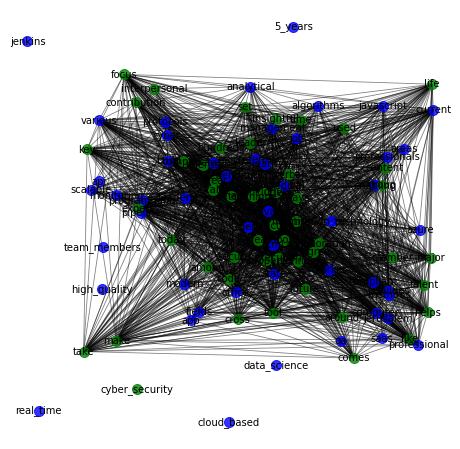

In [30]:
communities_paint(H,kernighan,labels,'kernighan–lin_bipartition_graph')

***Modularity-based communities algorithm***

In [31]:
Modularity = greedy_modularity_communities(H)
print("The number of communities divided by the Modularity-based communities algorithm: ",len(Modularity))
# Displays multiple nodes that appear in each community
print(list(Modularity))

The number of communities divided by the Modularity-based communities algorithm:  11
[frozenset({0, 2, 3, 6, 9, 10, 12, 13, 14, 16, 23, 26, 33, 34, 35, 39, 40, 41, 43, 44, 45, 47, 48, 51, 52, 53, 54, 56, 61, 62, 66, 67, 68, 75, 77, 78, 81, 82, 83, 87, 89, 92, 93, 95, 96, 97}), frozenset({1, 4, 5, 7, 8, 11, 15, 18, 19, 20, 21, 22, 24, 27, 28, 29, 30, 31, 36, 37, 42, 46, 49, 50, 55, 57, 58, 59, 60, 63, 64, 69, 70, 71, 73, 74, 76, 79, 84, 86, 88, 90, 94, 98, 99}), frozenset({17}), frozenset({25}), frozenset({32}), frozenset({38}), frozenset({65}), frozenset({72}), frozenset({80}), frozenset({85}), frozenset({91})]


In [32]:
# Display the words that appear in each community
communities_words=communities_words_list(Modularity,df_node)
print(communities_words)

[['modern', 'used', 'among', 'degree', 'member', 'drive', 'support', 'life', 'state', 'scale', 'great', 'fields', 'computer', 'take', 'current', 'around', 'leader', 'cross', 'api', 'areas', 'future', 'market', 'planning', 'key', 'focus', 'learn', 'time', 'ways', 'major', 'today', 'group', 'set', 'talent', 'jerusalem', 'include', 'like', 'operation', 'job', 'entire', 'response', 'make', 'office', 'comes', 'hundreds', 'smart', 'practice'], ['saas', 'enabling', 'secure', 'ideas', 'collaboration', 'verbal', 'medical', 'azure', 'insightful', 'pipeline', 'scalable', 'qa', 'tool', 'leadership', 'content', 'programming', 'technique', 'app', 'html', 'independent', 'execution', 'monitoring', 'compliant', 'professionals', 'build', 'management', 'analytical', 'helps', 'javascript', 'contribution', 'cyber', 'various', 'code', 'interpersonal', 'client', 'innovation', 'methods', 'provides', 'algorithms', 'talents', 'protocols', 'professional', 'expert', 'complex', 'preferred'], ['team_members'], ['je

In [33]:
df_greedy_modularity=add_number_cluster(df_node,communities_words,'greedy_modularity')
df_greedy_modularity.head()

,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity,greedy_modularity
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459,0
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757,1
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574,0
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322,0
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587,1


In [34]:
# Save in the file all the data for the clusters
df_greedy_modularity.to_csv(url+'greedy_modularity.csv',index=False)

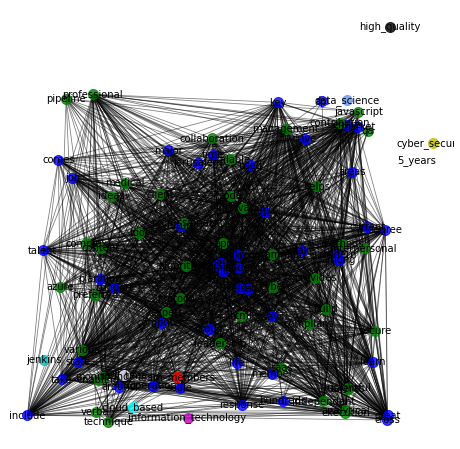

In [35]:
communities_paint(H,Modularity,labels,'modularity-based_graph')

***K-Clique algorithm***

In [36]:
k_clique = list(community.k_clique_communities(H,4))
print("The number of communities divided by the K-Clique algorithm: ",len(k_clique))
# Displays multiple nodes that appear in each community
print(k_clique)

The number of communities divided by the K-Clique algorithm:  1
[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99})]


In [37]:
# Display the words that appear in each community
communities_words=communities_words_list(k_clique,df_node)
print(list(communities_words))

[['modern', 'saas', 'used', 'among', 'enabling', 'secure', 'degree', 'ideas', 'collaboration', 'member', 'drive', 'verbal', 'support', 'life', 'state', 'medical', 'scale', 'azure', 'insightful', 'pipeline', 'scalable', 'qa', 'great', 'tool', 'fields', 'leadership', 'content', 'programming', 'technique', 'app', 'computer', 'take', 'current', 'html', 'independent', 'around', 'leader', 'cross', 'execution', 'api', 'areas', 'future', 'monitoring', 'market', 'planning', 'compliant', 'professionals', 'key', 'focus', 'learn', 'time', 'build', 'ways', 'management', 'analytical', 'helps', 'javascript', 'major', 'today', 'contribution', 'cyber', 'group', 'set', 'talent', 'various', 'code', 'interpersonal', 'client', 'innovation', 'jerusalem', 'methods', 'include', 'like', 'provides', 'operation', 'job', 'entire', 'algorithms', 'talents', 'response', 'protocols', 'make', 'professional', 'office', 'comes', 'expert', 'hundreds', 'smart', 'practice', 'complex', 'preferred']]


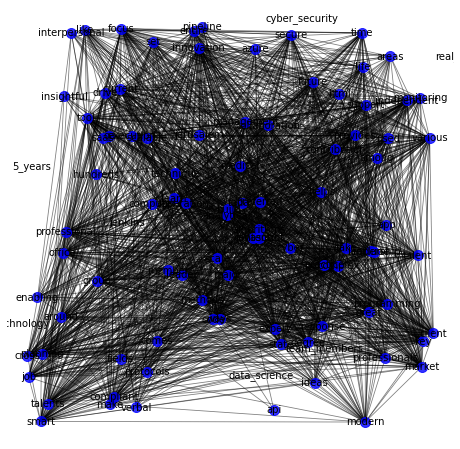

In [38]:
unfrozen_k_clique = [list(x) for x in k_clique]
communities_paint(H,unfrozen_k_clique,labels,'k-clique_graph')

## community_louvain

In [39]:
def get_partition_louvain(H):
    '''
    A function that runs the louvain algorithm on the graph
    '''
    partition = community_louvain.best_partition(H.to_undirected(), weight='weight', randomize=False)
    return partition

In [40]:
partition=get_partition_louvain(H)
partition

{0: 0,
 1: 19,
 2: 2,
 3: 2,
 4: 19,
 5: 19,
 6: 2,
 7: 2,
 8: 19,
 9: 2,
 10: 2,
 11: 19,
 12: 2,
 13: 2,
 14: 2,
 15: 19,
 16: 0,
 17: 3,
 18: 19,
 19: 19,
 20: 19,
 21: 19,
 22: 19,
 23: 2,
 24: 19,
 25: 19,
 26: 0,
 27: 19,
 28: 19,
 29: 19,
 30: 19,
 31: 0,
 32: 4,
 33: 0,
 34: 2,
 35: 2,
 36: 19,
 37: 19,
 38: 5,
 39: 2,
 40: 2,
 41: 2,
 42: 19,
 43: 0,
 44: 19,
 45: 2,
 46: 19,
 47: 0,
 48: 2,
 49: 19,
 50: 19,
 51: 2,
 52: 2,
 53: 2,
 54: 2,
 55: 0,
 56: 2,
 57: 19,
 58: 19,
 59: 2,
 60: 19,
 61: 2,
 62: 2,
 63: 19,
 64: 0,
 65: 6,
 66: 2,
 67: 2,
 68: 2,
 69: 19,
 70: 2,
 71: 19,
 72: 7,
 73: 19,
 74: 19,
 75: 19,
 76: 19,
 77: 2,
 78: 2,
 79: 19,
 80: 8,
 81: 2,
 82: 2,
 83: 2,
 84: 19,
 85: 9,
 86: 19,
 87: 2,
 88: 19,
 89: 2,
 90: 19,
 91: 10,
 92: 0,
 93: 2,
 94: 19,
 95: 2,
 96: 2,
 97: 2,
 98: 19,
 99: 19,
 100: 2,
 101: 19,
 102: 19,
 103: 2,
 104: 0,
 105: 2,
 106: 19,
 107: 19,
 108: 0,
 109: 2,
 110: 19,
 111: 2,
 112: 0,
 113: 11,
 114: 2,
 115: 12,
 116: 19,
 117: 

In [41]:
def get_label_dict_louvain(H):
    '''
    # Create a dictionary where the key is the vertex value and the value is the vertex name for louvain algorithm
    '''
    word_click = []
    for i in list(partition.keys()):
         word_click.append(list(df_node.word[df_node.index ==i].values)[0])

    label_dict= dict(zip(list(partition.keys()),word_click))
    return label_dict

In [42]:
labeldict=get_label_dict_louvain(H)
labeldict

{0: 'modern',
 1: 'saas',
 2: 'used',
 3: 'among',
 4: 'enabling',
 5: 'secure',
 6: 'degree',
 7: 'ideas',
 8: 'collaboration',
 9: 'member',
 10: 'drive',
 11: 'verbal',
 12: 'support',
 13: 'life',
 14: 'state',
 15: 'medical',
 16: 'scale',
 17: 'team_members',
 18: 'azure',
 19: 'insightful',
 20: 'pipeline',
 21: 'scalable',
 22: 'qa',
 23: 'great',
 24: 'tool',
 25: 'jenkins',
 26: 'fields',
 27: 'leadership',
 28: 'content',
 29: 'programming',
 30: 'technique',
 31: 'app',
 32: 'information_technology',
 33: 'computer',
 34: 'take',
 35: 'current',
 36: 'html',
 37: 'independent',
 38: 'cyber_security',
 39: 'around',
 40: 'leader',
 41: 'cross',
 42: 'execution',
 43: 'api',
 44: 'areas',
 45: 'future',
 46: 'monitoring',
 47: 'market',
 48: 'planning',
 49: 'compliant',
 50: 'professionals',
 51: 'key',
 52: 'focus',
 53: 'learn',
 54: 'time',
 55: 'build',
 56: 'ways',
 57: 'management',
 58: 'analytical',
 59: 'helps',
 60: 'javascript',
 61: 'major',
 62: 'today',
 63: 'c

In [43]:
df_node_louvain=df_node
df_node_louvain['louvain'] = partition.values()
df_node_louvain['louvain'].value_counts()

19    205
2     191
0      62
14      1
26      1
25      1
24      1
23      1
22      1
21      1
20      1
18      1
17      1
16      1
15      1
13      1
28      1
12      1
11      1
10      1
9       1
8       1
7       1
6       1
5       1
4       1
3       1
1       1
27      1
58      1
57      1
44      1
56      1
55      1
54      1
53      1
52      1
51      1
50      1
49      1
48      1
47      1
46      1
45      1
43      1
30      1
42      1
41      1
40      1
39      1
38      1
37      1
36      1
35      1
34      1
33      1
32      1
31      1
29      1
Name: louvain, dtype: int64

In [44]:
df_node_louvain.head()

,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity,louvain
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459,0
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757,19
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574,2
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322,2
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587,19


In [45]:
df_node_louvain.to_csv(url+'df_nodes_louvian.csv',index=False)

In [46]:
def get_graph_louvain(H,labeldict,partition):
    '''
    A function that displays a graph of the louvain algorithm
    '''
    # draw the graph
    pos = nx.spring_layout(H, iterations=1)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(H, pos, partition.keys(), node_size=90, 
                            cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(H, pos,width=0.8, alpha=0.5)
    nx.draw_networkx_labels(H, pos, labeldict,font_size=10)

    plt.gcf().set_size_inches(10,10)
    plt.axis('off')
    plt.show()

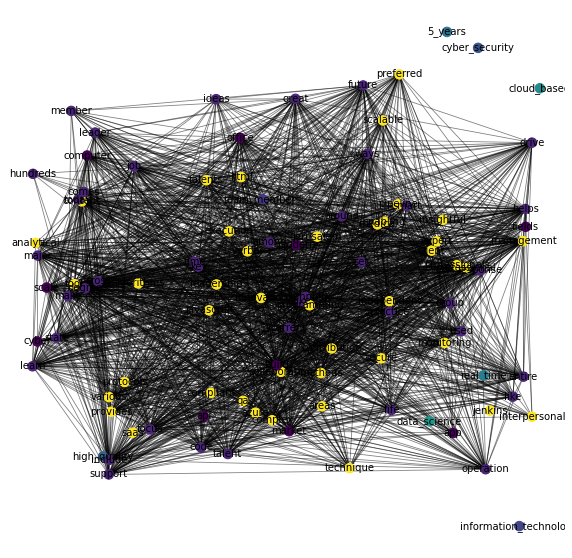

In [47]:
get_graph_louvain(H.subgraph(range(100)),{k: labeldict[k] for k in list(labeldict)[:100]},{k: partition[k] for k in list(partition)[:100]})

In [48]:
# Reading a csv file that contains nodes of the graph
df_node_louvain = pd.read_csv(url+'df_nodes_louvian.csv', converters={'tf_idf': eval, 'tf_idf_after_norm':eval,'wordvec':eval}) 

# ***Kmeans***

In [49]:
df_node_kmeans=df_node
# Removing a column from the data frame
df_node_kmeans=df_node_kmeans.drop('louvain',axis='columns')

In [50]:
def get_kmeans(df_node_kmeans):
    '''
    A function that runs the kmeans algorithm
    '''
    # Creating a matrix of tf-idf values
    X = np.array([value_tf_idf for value_tf_idf in df_node_kmeans['tf-idf']])
    print(X.shape)
    # Calculate kmeans for k = 5 clusters
    kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
    df_node_kmeans['kmeans_clusters'] = kmeans.labels_
    return df_node_kmeans
    

In [51]:
df_node_kmeans=get_kmeans(df_node_kmeans)
df_node_kmeans.head()

(514, 699)


,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity,kmeans_clusters
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459,0
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757,0
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574,0
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322,0
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587,0


In [52]:
# Save in the file all the data for the clusters
df_node_kmeans.to_csv(url+'df_node_kmeans_algorithms.csv',index=False)

In [53]:
def displays_cluster_kmeans(df_node_kmeans):
    '''
    A function that displays a cluster number and the words that appear in it
    '''
    dict_kmeans_words={ key : [*map(lambda value: value[1], values)]
        for key, values in itertools.groupby(sorted(list(zip(df_node_kmeans['kmeans_clusters'], df_node_kmeans['word'])), key=lambda x: x[0]), lambda x: x[0])
        }
    dict_kmeans_words={"claster "+ str(key):value for key,value in dict_kmeans_words.items()}

    for item in dict_kmeans_words.items():
      print(item)

In [54]:
displays_cluster_kmeans(df_node_kmeans)

('claster 0', ['modern', 'saas', 'used', 'among', 'enabling', 'secure', 'degree', 'ideas', 'collaboration', 'member', 'drive', 'verbal', 'support', 'life', 'state', 'scale', 'team_members', 'insightful', 'pipeline', 'great', 'tool', 'jenkins', 'fields', 'leadership', 'content', 'technique', 'app', 'information_technology', 'computer', 'take', 'current', 'html', 'independent', 'cyber_security', 'around', 'leader', 'cross', 'execution', 'areas', 'future', 'monitoring', 'market', 'planning', 'compliant', 'professionals', 'key', 'focus', 'learn', 'time', 'build', 'ways', 'management', 'analytical', 'helps', 'major', 'today', 'contribution', 'cyber', 'high_quality', 'group', 'set', 'talent', 'interpersonal', 'methods', 'like', 'provides', 'operation', 'job', 'entire', 'cloud_based', 'talents', 'response', 'protocols', 'make', 'professional', 'comes', 'expert', 'hundreds', 'smart', 'practice', 'complex', 'preferred', 'within', 'ownership', 'practices', 'many', 'windows', 'vision', 'rapidly',

In [55]:
# Displays the amount of words in each cluster
df_node_kmeans.kmeans_clusters.value_counts()

0    409
4     95
2      5
3      4
1      1
Name: kmeans_clusters, dtype: int64